Example of wheel in contact (Assembly between two meshes, transformations, use of fixed size variables)
=======================================================================================================

 Copyright (C) 2019 Yves Renard, Tetsuo Koyama.

 This file is a part of GetFEM++

 GetFEM++  is  free software;  you  can  redistribute  it  and/or modify it
 under  the  terms  of the  GNU  Lesser General Public License as published
 by  the  Free Software Foundation;  either version 3 of the License,  or
 (at your option) any later version along with the GCC Runtime Library
 Exception either version 3.1 or (at your option) any later version.
 This program  is  distributed  in  the  hope  that it will be useful,  but
 WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
 or  FITNESS  FOR  A PARTICULAR PURPOSE.  See the GNU Lesser General Public
 License and GCC Runtime Library Exception for more details.
 You  should  have received a copy of the GNU Lesser General Public License
 along  with  this program;  if not, write to the Free Software Foundation,
 Inc., 51 Franklin St, Fifth Floor, Boston, MA  02110-1301, USA.

 As a special exception, you  may use  this file  as it is a part of a free
 software  library  without  restriction.  Specifically,  if   other  files
 instantiate  templates  or  use macros or inline functions from this file,
 or  you compile this  file  and  link  it  with other files  to produce an
 executable, this file  does  not  by itself cause the resulting executable
 to be covered  by the GNU Lesser General Public License.  This   exception
 does not  however  invalidate  any  other  reasons why the executable file
 might be covered by the GNU Lesser General Public License.

In this example of a deformable ''wheel'' enters in contact with a deformable foundation. We use here python interface, translate this program for another interface or in C++ is easy (see the previous example). The complete program  `demo_wheel_contact.py` can be found in the directory `interface/tests/python`.

The problem setting
-------------------

Let $\Omega^1 \subset \R^2$ be the reference configuration of a 2D wheel and $\Omega^2 \subset \R^2$ the reference configuration of a deformable foundation. We consider small deformation of these two bodies (linearized elasticity) and the contact between them. We also consider that the rim of the wheel is rigid and apply a vertical force on the wheel.

Building the program
--------------------

Let us begin by loading Getfem and fixing the parameters of the problem

In [1]:
import getfem as gf
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import meshio

E = 21E6                         # Young Modulus (N/cm^2)
nu = 0.3                         # Poisson ratio
clambda = E*nu/((1+nu)*(1-2*nu)) # First Lame coefficient (N/cm^2)
cmu = E/(2*(1+nu))               # Second Lame coefficient (N/cm^2)
clambdastar = 2*clambda*cmu/(clambda+2*cmu) # Lame coefficient for Plane stress (N/cm^2)
applied_force = 1E7              # Force at the hole boundary (N)

h = 1                      # Approximate mesh size
elements_degree = 2        # Degree of the finite element methods
gamma0 = 1./E;             # Augmentation parameter for the augmented Lagrangian

Mesh generation
***************

We consider that the radius of the wheel is 15cm and the one of the rim 8cm and that the wheel lies on a deformable foundation of thickness 10cm. We generate the mesh of the wheel using the experimental mesher of GetFEM++. Concerning the mesh of the foundation, we build a structured mesh (see the documentation of the Mesh object in the python interface).

In [2]:
mo1 = gf.MesherObject('ball', [0., 15.], 15.)
mo2 = gf.MesherObject('ball', [0., 15.], 8.)
mo3 = gf.MesherObject('set minus', mo1, mo2)
gf.util('trace level', 2)   # No trace for mesh generation
mesh1 = gf.Mesh('generate', mo3, h, elements_degree)
mesh2 = gf.Mesh('import','structured','GT="GT_PK(2,1)";SIZES=[30,10];NOISED=0;NSUBDIV=[%d,%d];' % (int(30/h)+1, int(10/h)+1));
mesh2.translate([-15.,-10.])

# OutputMeshSlice
sl1 = gf.Slice(('none',), mesh1, 1)
sl2 = gf.Slice(('none',), mesh2, 1)
sl1.export_to_vtk('sl1.vtk', 'ascii')
sl2.export_to_vtk('sl2.vtk', 'ascii')

# ReadMeshSlice
reader1 = meshio.read('sl1.vtk')
reader2 = meshio.read('sl2.vtk')
x1 = reader1.points
x2 = reader2.points
triangles1 = reader1.cells['triangle']
triangles2 = reader2.cells['triangle']

The result is the following

In [3]:
import k3d
import os
import vtk

filename1 = 'sl1.vtk'
filename2 = 'sl2.vtk'
    
reader1 = vtk.vtkUnstructuredGridReader()
reader1.SetFileName(filename1)
reader1.Update()
    
reader2 = vtk.vtkUnstructuredGridReader()
reader2.SetFileName(filename2)
reader2.Update()

geometryFilter1 = vtk.vtkGeometryFilter()
geometryFilter1.SetInputData(reader1.GetOutput())
geometryFilter1.Update()

geometryFilter2 = vtk.vtkGeometryFilter()
geometryFilter2.SetInputData(reader2.GetOutput())
geometryFilter2.Update()

plot = k3d.plot()
vtk_poly_data1 = k3d.vtk_poly_data(geometryFilter1.GetOutput())
vtk_poly_data2 = k3d.vtk_poly_data(geometryFilter2.GetOutput())
plot += vtk_poly_data1
plot += vtk_poly_data2
plot.display()

Output()

In [4]:
plot.fetch_screenshot()

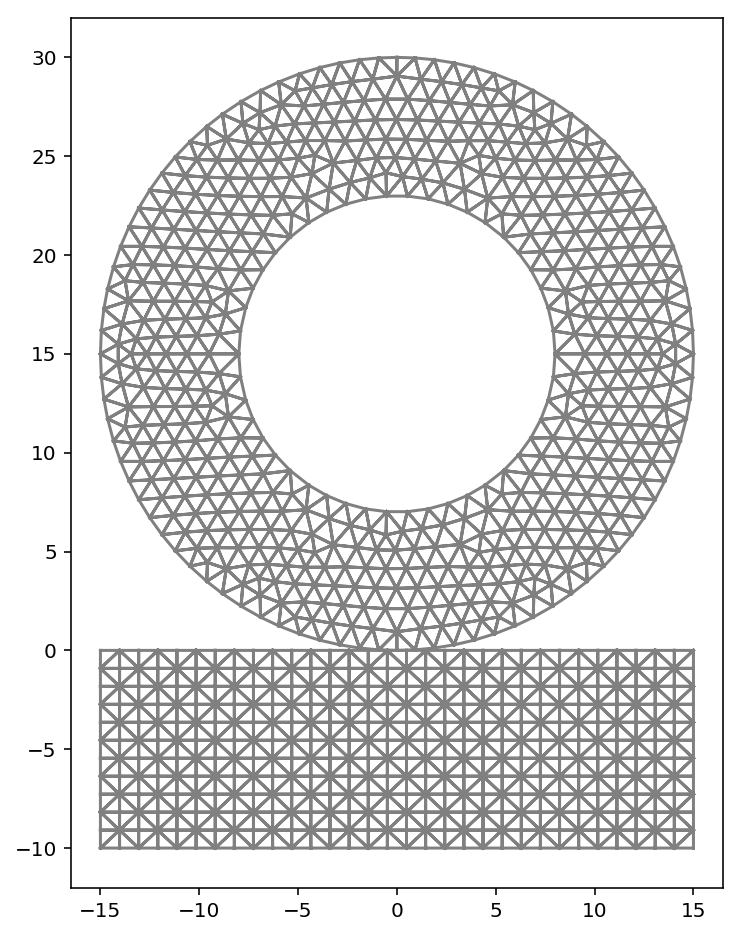

In [5]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.figure(figsize=(8, 8))
plt.triplot(x1[:,0], x1[:,1], triangles1, color='gray')
plt.triplot(x2[:,0], x2[:,1], triangles2, color='gray')
plt.gca().set_aspect('equal')

Boundary selection
******************

We have to select the different parts of the boundary where we will set some boundary conditions, namely the boundary of the rim (in order to apply a force and the fact that the rim is rigid), the contact boundary of the wheel and the bottom boundary of the foundation that we will assume clamped.

In [6]:
fb1 = mesh1.outer_faces_in_box([-8.1, 6.9], [8.1, 23.1])     # Boundary of the hole
fb2 = mesh1.outer_faces_with_direction([0., -1.], np.pi/4.5) # Contact boundary of the wheel
fb3 = mesh2.outer_faces_with_direction([0., -1.], 0.01)      # Bottom boundary of the foundation

HOLE_BOUND=1; CONTACT_BOUND=2; BOTTOM_BOUND=3;

mesh1.set_region(HOLE_BOUND, fb1)
mesh1.set_region(CONTACT_BOUND, fb2)
mesh1.region_subtract(CONTACT_BOUND, HOLE_BOUND)
mesh2.set_region(BOTTOM_BOUND, fb3)

Note that the command `mesh1.outer_faces_with_direction([0., -1.], n.pi/4)` allows to select all the faces having a unit outward normal having an angle less or equal to `n.pi/4` with the vector `[0., -1.]`. The command `mesh1.region_subtract(CONTACT_BOUND, HOLE_BOUND)` allow to delete the faces corresponding to the rim in the contact boundary.

Definition of finite elements methods and integration method
************************************************************

We define `mfu1`, `mfu2` two finite element methods which will approximate the displacements in the wheel and the foundation respectively. `mflambda` is  finite element method to approximate a multiplier to take into account the rigidity of the rim, `mflambda_C` is to approximate the contact multiplier (contact pressure) and `mfvm1`, `mfvm2` will be used to interpolate the Von Mises stresses of the wheel and the foundation for post-processing. `mim1`, `mim2` are two integration methods on the  wheel and the foundation.

In [7]:
mfu1 = gf.MeshFem(mesh1, 2)
mfu1.set_classical_fem(elements_degree)
mflambda = gf.MeshFem(mesh1, 2)
mflambda.set_classical_fem(elements_degree-1)
mflambda_C = gf.MeshFem(mesh1, 1)
mflambda_C.set_classical_fem(elements_degree-1)
mfu2 = gf.MeshFem(mesh2, 2)
mfu2.set_classical_fem(elements_degree)
mfvm1 = gf.MeshFem(mesh1, 1)
mfvm1.set_classical_discontinuous_fem(elements_degree)
mfvm2 = gf.MeshFem(mesh2, 1)
mfvm2.set_classical_discontinuous_fem(elements_degree)
mim1 = gf.MeshIm(mesh1, pow(elements_degree,2))
mim2 = gf.MeshIm(mesh2, pow(elements_degree,2))
# for plot
mfe1 = gf.MeshFem(mesh1, 2)
mfe1.set_classical_fem(1)
mfe2 = gf.MeshFem(mesh2, 2)
mfe2.set_classical_fem(1)
mff1 = gf.MeshFem(mesh1, 1)
mff1.set_classical_discontinuous_fem(1)
mff2 = gf.MeshFem(mesh2, 1)
mff2.set_classical_discontinuous_fem(1)

Model definition
****************

We use a real model and declare the two variables which will represent the displacements:

In [8]:
md=gf.Model('real');
md.add_fem_variable('u1', mfu1)
md.add_fem_variable('u2', mfu2)
# Displacement of the structure 1
# Displacement of the structure 2

Linearized elasticity bricks
****************************

We add the Lamé coefficients as data of the model and add a linearized elasticity brick for the wheel and the foundation:

In [9]:
md.add_initialized_data('cmu', [cmu])
md.add_initialized_data('clambdastar', [clambdastar])
md.add_isotropic_linearized_elasticity_brick(mim1, 'u1', 'clambdastar', 'cmu')
md.add_isotropic_linearized_elasticity_brick(mim2, 'u2', 'clambdastar', 'cmu')

1

Clamped condition at the bottom of the foundation
*************************************************

We prescribed the displacement at  bottom face of the foundation to vanish, for instance with a multiplier with the add of the following brick:

In [10]:
md.add_Dirichlet_condition_with_multipliers(mim2, 'u2', elements_degree-1, BOTTOM_BOUND)

2

Contact condition (use of interpolate transformations)
******************************************************

Now, let us see how to prescribed the contact condition between the two structures. It is possible to use predefined bricks (see  :ref:`ud-model-contact-friction` for small deformation/small sliding contact and :ref:`ud-model-contact-friction-large` for large deformation/large sliding contact). However, we will see here how to directly prescribe a contact condition using an augmented Lagrangian formulation and the interpolate transformations.

For small deformation contact, the correspondence between points of one contact surface to the other have to be described on the reference configuration and is not evolving, which is of course simpler but is an approximation. 

We consider that the contact boundary of the wheel is the slave one and we have to describe the transformation from the contact boundary of the wheel to the contact boundary of the foundation. This is quite simple here, since the contact boundary of the foundation corresponds to a vanishing vertical coordinate. So we define the transformation

$$
X \longmapsto (X(1), 0)
$$

where $X$ is the vector of coordinates of the point. We add this transformation to the model with the command

In [11]:
md.add_interpolate_transformation_from_expression('Proj1', mesh1, mesh2, '[X(1);0]')

As a consequence, it will be possible to use this transformation, from the mesh of the wheel to the mesh of the foundation, into weak form language expressions. Notes that this is here a very simple constant expression. More complex expressions depending on the data or even the variables of the model can be used. If the expression of a transformation depends on the variable of the model, the tangent linear system will automatically takes into account this dependence (see :ref:`ud-gasm-high-transf` for more details. Note also that transformation corresponding to a large sliding contact and automatically searching for the correspondence between contact boundaries exist in |gf| (see :ref:`ud-model-contact-friction-large-hlgav`).
 
Using the defined transformation, we can write an integral contact condition using an augmented Lagrangian formulation (see :ref:`ud-model-contact-friction` for more details). The corresponding term (to be added to the rest of the weak formulation) reads:
$$
\cdots + \int_{\Gamma_c} \lambda_N(X) (\delta_{u^1}(X)-\delta_{u^2}(\Pi(X)))\cdot n d\Gamma - \int_{\Gamma_c} \left(\lambda_N(X) + \left(\lambda_N(X) + \frac{1}{h_T\gamma_0}((X + u^1(X))\cdot n - (\Pi(X) - u^2(\Pi(X)))\cdot n\right)_-\right)\delta_{\lambda_N}(X) d\Gamma = 0 ~~~~ \forall \delta_{\lambda_N}, \forall \delta_{u^1}, \forall \delta_{u^2},
$$
where $\Gamma_c$ is the slave contact boundary, $\lambda_N$ is the contact multiplier (contact pressure), $h_T$ is the radius of the element, $\Pi$ is the transformation, $n$ is the outward normal vector to the master contact boundary (here $n = (0,1)$), $\gamma_0$ is an augmentation parameter, $(\cdot)_-:I\hspace{-0.2em}R\rightarrow I\hspace{-0.2em}R_+$ is the negative part and $\delta_{\lambda_N}, \delta_{u^1}, \delta_{u^2}$ are the test  functions corresponding to $\lambda_N, u^1, u^2$, respectively.

Using the weak form language, the contact condition can be added by:

In [12]:
md.add_initialized_data('gamma0', [gamma0])
md.add_filtered_fem_variable('lambda1', mflambda_C, CONTACT_BOUND)
md.add_nonlinear_generic_assembly_brick(mim1, 'lambda1*(Test_u1.[0;1])'
                    '-lambda1*(Interpolate(Test_u2,Proj1).[0;1])', CONTACT_BOUND)
md.add_nonlinear_generic_assembly_brick(mim1, '-(gamma0*element_size)'
          '*(lambda1 + neg_part(lambda1+(1/(gamma0*element_size))'
          '*((u1-Interpolate(u2,Proj1)+X-Interpolate(X,Proj1)).[0;1])))*Test_lambda1', CONTACT_BOUND);

Prescribing the rigidity of the rim and the vertical force
**********************************************************

We have now to prescribe the rigidity of the rim. This is a non-standard condition, since we do not know a priori what will be the vertical displacement of the rim. We can use an additional unknown for that vertical displacement. We add an additional fixed size variable `alpha_D` (which mean that it does not a finite element field) of size 1 with

In [13]:
md.add_variable('alpha_D', 1)

We need a multiplier to prescribe the displacement on the rim boundary:

In [14]:
md.add_filtered_fem_variable('lambda_D', mflambda, HOLE_BOUND)

This multiplier represents the boundary stress that is necessary to prescribe the vertical displacement to be $(0, -\alpha_D)$. The constraint we want to apply on this multiplier is that its integral over the rim boundary is the vertical force we want to apply. The corresponding weak formulation term to be added to the rest of the weak formulation reads
$$
  \cdots + \int_{\Gamma_D} -\lambda_D.\delta_{u^1} + ((0, \alpha_D) - u^1).\delta_{\lambda_D} + (\lambda_D.(0,1) + F)\delta_{\alpha_D} d\Gamma = 0,
$$
where $\Gamma_D$ is the rim boundary, $F$ is the applied density of force.

This could be added to the model with the weak form language:

In [15]:
md.add_initialized_data('F', [applied_force/(8*2*np.pi)])
md.add_linear_generic_assembly_brick(mim1, '-lambda_D.Test_u1 + (alpha_D*[0;1]-u1).Test_lambda_D'
      ' + (lambda_D.[0;1]+F)*Test_alpha_D', HOLE_BOUND)

6

For more robustness, a small penalization on $\alpha_D$ can be added

In [16]:
md.add_linear_generic_assembly_brick(mim1, '1E-6*alpha_D*Test_alpha_D');

Note that the fixed size variable `alpha_D` is linked to each points of the rim boundary. This means that the line of the tangent matrix corresponding to `alpha_D` may have a lot of nonzero components. This is why such a use of fixed size variable have to be done with care.

Model solve
***********

We can now solve our problem with:

In [17]:
md.solve('max_res', 1E-9, 'max_iter', 100, 'noisy')

(7, 1)

Note that in some configuration, it is preferable to use a more basic line search than the default one:

md.solve('max_res', 1E-9, 'max_iter', 100, 'noisy', 'lsearch', 'simplest',  'alpha min', 0.8)

Export the solution
*******************

Now the code to export the solution with the VonMiss stress:

In [18]:
U1 = md.variable('u1')
U2 = md.variable('u2')
VM1 = md.compute_isotropic_linearized_Von_Mises_or_Tresca('u1', 'clambdastar', 'cmu', mfvm1)
VM2 = md.compute_isotropic_linearized_Von_Mises_or_Tresca('u2', 'clambdastar', 'cmu', mfvm2)
VM1SL = gf.compute_interpolate_on(mfvm1, VM1, sl1)
VM2SL = gf.compute_interpolate_on(mfvm2, VM2, sl2)

sl1.export_to_vtk('von_mises1.vtk', 'ascii', mff1,  VM1SL, 'Von_Mises_Stresses')
sl2.export_to_vtk('von_mises2.vtk', 'ascii', mff2,  VM2SL, 'Von_Mises_Stresses')

Plot of the solution.

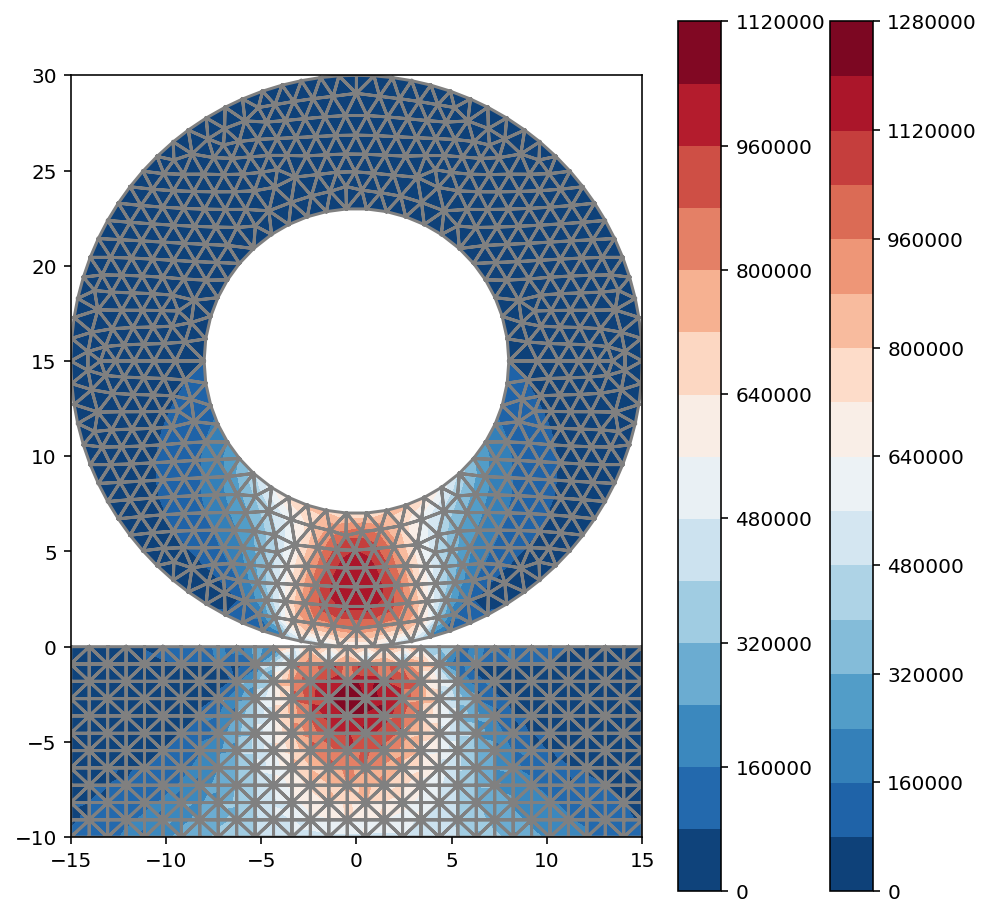

In [19]:
reader1 = meshio.read('von_mises1.vtk')
reader2 = meshio.read('von_mises2.vtk')
x1 = reader1.points
x2 = reader2.points
triangles1 = reader1.cells['triangle']
triangles2 = reader2.cells['triangle']

vm1 = reader1.point_data['Von_Mises_Stresses']
vm2 = reader2.point_data['Von_Mises_Stresses']

plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.figure(figsize=(8, 8))
plt.triplot(x1[:,0], x1[:,1], triangles1, color='gray')
plt.triplot(x2[:,0], x2[:,1], triangles2, color='gray')
cntr1 = plt.tricontourf(x1[:,0], x1[:,1], triangles1, vm1, 16, cmap="RdBu_r");
cntr2 = plt.tricontourf(x2[:,0], x2[:,1], triangles2, vm2, 16, cmap="RdBu_r");
plt.colorbar(cntr1)
plt.colorbar(cntr2)
plt.gca().set_aspect('equal')

In [20]:
import k3d
import os
import vtk

filename1 = 'von_mises1.vtk'
filename2 = 'von_mises2.vtk'
    
reader1 = vtk.vtkUnstructuredGridReader()
reader1.SetFileName(filename1)
reader1.Update()
    
reader2 = vtk.vtkUnstructuredGridReader()
reader2.SetFileName(filename2)
reader2.Update()

geometryFilter1 = vtk.vtkGeometryFilter()
geometryFilter1.SetInputData(reader1.GetOutput())
geometryFilter1.Update()

geometryFilter2 = vtk.vtkGeometryFilter()
geometryFilter2.SetInputData(reader2.GetOutput())
geometryFilter2.Update()

plot = k3d.plot()
vtk_poly_data1 = k3d.vtk_poly_data(geometryFilter1.GetOutput())
vtk_poly_data2 = k3d.vtk_poly_data(geometryFilter2.GetOutput())
plot += vtk_poly_data1
plot += vtk_poly_data2
plot.display()

Output()